In [1]:
%matplotlib inline
# Dependencies and Setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import requests
from scipy.stats import linregress
from pprint import pprint
import scipy.stats as st
import scipy.stats as stats

In [2]:
# Mobility data
mobility_file = "data/2020_AU_Region_Mobility_Report.csv"
mobility_df = pd.read_csv(mobility_file)

mobility_df.head(3)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AU,Australia,NaN,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-15,4.0,3.0,-2.0,3.0,3.0,0.0
1,AU,Australia,NaN,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-16,3.0,5.0,9.0,3.0,-1.0,0.0
2,AU,Australia,NaN,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-17,-1.0,0.0,-6.0,7.0,17.0,-2.0


In [3]:
# Covid data
covid_file = "data/covid-19-all.csv"
covid_df = pd.read_csv(covid_file)

covid_df.head(3)

C:\Users\arron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
0,NaN,NaN,NaN,NaN,51526.0,41727.0,2191.0,2021-01-01
1,NaN,NaN,NaN,NaN,58316.0,33634.0,1181.0,2021-01-01
2,NaN,NaN,NaN,NaN,99897.0,67395.0,2762.0,2021-01-01


### Cleansing Mobility data and grouping data to state level

In [4]:
# Format "Date" to datetime
mobility_df["date"]=pd.to_datetime(mobility_df["date"])

In [5]:
# Mobililty data is at sub-region_2 level. Therefore, mean or median of mobility index is calculated group by state and date
stategrp_df = mobility_df.groupby(["country_region","sub_region_1","date"])

retail_recreation = stategrp_df.retail_and_recreation_percent_change_from_baseline.median()
grocery_pharmacy = stategrp_df.grocery_and_pharmacy_percent_change_from_baseline.median()
parks = stategrp_df.parks_percent_change_from_baseline.median()
transit_stations = stategrp_df.transit_stations_percent_change_from_baseline.median()
workplaces = stategrp_df.workplaces_percent_change_from_baseline.median()
residential = stategrp_df.residential_percent_change_from_baseline.median()

# New state dataframe
state_mobility_df = pd.DataFrame({"retail_recreation_pctchange_to_baseline": retail_recreation,
                                    "grocery_pharmacy_pctchange_to_baseline": grocery_pharmacy,
                                    "parks_pctchange_to_baseline": parks,
                                    "transit_stations_pctchange_to_baseline": transit_stations,
                                    "workplaces_pctchange_to_baseline": workplaces,
                                    "residential_pctchange_to_baseline": residential
                                    }) 
#Reset index
state_mobility_df = state_mobility_df.reset_index()

#Rename columns
state_mobility_df = state_mobility_df.rename(columns={"sub_region_1":"state"})

state_mobility_df.head(3)

,country_region,state,date,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
0,Australia,Australian Capital Territory,2020-02-15,7.0,5.0,28.0,4.0,6.0,-1.0
1,Australia,Australian Capital Territory,2020-02-16,8.0,19.0,34.0,16.0,2.0,-2.0
2,Australia,Australian Capital Territory,2020-02-17,-1.0,10.0,9.0,21.0,25.0,-4.0


### Create & Cleasing AU Covid Dataframe

In [6]:
columns = ["Country/Region","Province/State","Latitude","Longitude","Date","Confirmed","Deaths"]

au_covid_df = covid_df.loc[covid_df["Country/Region"]=="Australia",columns]

#Reset index
au_covid_df = au_covid_df.reset_index(drop=True)

au_covid_df.head()

,Country/Region,Province/State,Latitude,Longitude,Date,Confirmed,Deaths
0,Australia,NaN,-33.8688,144.9631,2020-01-23,NaN,NaN
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,NaN
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,NaN
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,NaN
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,NaN


In [7]:
# Replace n/a Covid case number with zero
au_covid_df["Confirmed"]=au_covid_df["Confirmed"].fillna(0)
au_covid_df["Deaths"]=au_covid_df["Deaths"].fillna(0)

au_covid_df.head()

,Country/Region,Province/State,Latitude,Longitude,Date,Confirmed,Deaths
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0


In [8]:
# Format "Date" to datetime
au_covid_df["Date"]=pd.to_datetime(au_covid_df["Date"])

au_covid_df.tail(3)

,Country/Region,Province/State,Latitude,Longitude,Date,Confirmed,Deaths
2593,Australia,Tasmania,-42.8821,147.3272,2020-12-31,234.0,13.0
2594,Australia,Victoria,-37.8136,144.9631,2020-12-31,20376.0,820.0
2595,Australia,Western Australia,-31.9505,115.8605,2020-12-31,861.0,9.0


In [9]:
#Rename columns
au_covid_df = au_covid_df.rename(columns={"Country/Region":"country_region", "Province/State":"state", "Date":"date"})


In [10]:
au_covid_df.head()

,country_region,state,Latitude,Longitude,date,Confirmed,Deaths
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0


### Final Working Dataframe

In [11]:
# Merge the two dataframe together with all covid data outer join 
working_df = pd.merge(au_covid_df,state_mobility_df, how="left",on=["country_region", "state", "date"])

working_df.head()

,country_region,state,Latitude,Longitude,date,Confirmed,Deaths,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Mobility with N/A is considered as baseline. Therefore, update all N/A to be zero
working_df["retail_recreation_pctchange_to_baseline"]=working_df["retail_recreation_pctchange_to_baseline"].fillna(0)
working_df["grocery_pharmacy_pctchange_to_baseline"]=working_df["grocery_pharmacy_pctchange_to_baseline"].fillna(0)
working_df["parks_pctchange_to_baseline"]=working_df["parks_pctchange_to_baseline"].fillna(0)
working_df["transit_stations_pctchange_to_baseline"]=working_df["transit_stations_pctchange_to_baseline"].fillna(0)
working_df["workplaces_pctchange_to_baseline"]=working_df["workplaces_pctchange_to_baseline"].fillna(0)
working_df["residential_pctchange_to_baseline"]=working_df["residential_pctchange_to_baseline"].fillna(0)

working_df.head()

,country_region,state,Latitude,Longitude,date,Confirmed,Deaths,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Arron's Section

In [13]:
# Analysing total average changes accross all Catergories
retail_avg_change = working_df.groupby('state')['retail_recreation_pctchange_to_baseline'].mean()
grocery_avg_change = working_df.groupby('state')['grocery_pharmacy_pctchange_to_baseline'].mean()
parks_avg_change = working_df.groupby('state')['parks_pctchange_to_baseline'].mean()
pt_avg_change = working_df.groupby('state')['transit_stations_pctchange_to_baseline'].mean()
workplace_avg_change = working_df.groupby('state')['workplaces_pctchange_to_baseline'].mean()
home_avg_change = working_df.groupby('state')['residential_pctchange_to_baseline'].mean()

In [14]:
# Merge to compare
avg_change_summary = pd.merge(retail_avg_change,grocery_avg_change,how="left",on=["state"])
avg_change_summary = pd.merge(avg_change_summary,parks_avg_change,how="left",on=["state"])
avg_change_summary = pd.merge(avg_change_summary,pt_avg_change,how="left",on=["state"])
avg_change_summary = pd.merge(avg_change_summary,workplace_avg_change,how="left",on=["state"])
avg_change_summary = pd.merge(avg_change_summary,home_avg_change,how="left",on=["state"])
avg_change_summary = pd.DataFrame(avg_change_summary)
avg_change_summary

,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
state,,,,,,
Australian Capital Territory,-15.108844,1.374150,7.979592,-34.108844,-15.955782,8.642857
External territories,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
From Diamond Princess,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Jervis Bay Territory,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
New South Wales,-10.835294,1.447059,-9.327941,-27.429412,-10.891176,6.785294
Northern Territory,6.387789,14.064356,25.917492,-27.140264,3.049505,2.480198
Queensland,-4.688427,2.345697,-3.913947,-23.713650,-6.942136,4.182493
South Australia,-8.286567,4.492537,-13.688060,-13.026866,-10.076119,5.716418
Tasmania,-18.940984,-8.273770,-43.001639,-41.149180,-8.993443,6.577049


In [15]:
# What was the Net average change for all categories across AU?
retail_avg_net_sum = avg_change_summary['retail_recreation_pctchange_to_baseline'].sum()
grocer_avg_net_sum = avg_change_summary['grocery_pharmacy_pctchange_to_baseline'].sum()
park_avg_net_sum = avg_change_summary['parks_pctchange_to_baseline'].sum()
pt_avg_net_sum = avg_change_summary['transit_stations_pctchange_to_baseline'].sum()
workplace_avg_net_sum = avg_change_summary['workplaces_pctchange_to_baseline'].sum()
home_avg_net_sum = avg_change_summary['residential_pctchange_to_baseline'].sum()

print(retail_avg_net_sum)
print(grocer_avg_net_sum)
print(park_avg_net_sum)
print(pt_avg_net_sum)
print(workplace_avg_net_sum)
print(home_avg_net_sum)

-81.30530261246024
15.766282183666632
-70.15179101844957
-237.39215654774438
-80.50676205281451
53.00247814218408


In [ ]:
# Overview
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['transit_stations_pctchange_to_baseline']
nsw = nsw_df['transit_stations_pctchange_to_baseline']
nt = nt_df['transit_stations_pctchange_to_baseline']
qld = qld_df['transit_stations_pctchange_to_baseline']
sa = sa_df['transit_stations_pctchange_to_baseline']
tas = tas_df['transit_stations_pctchange_to_baseline']
vic = vic_df['transit_stations_pctchange_to_baseline']
wa = wa_df['transit_stations_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.title("Public Transport % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(10, 50))
plt.show()


- We can see the areas that was hit the hardest was retail, parks, public transport and work places
- Movements to groceries and home actually had average increases to the baseline. We will exclude these locations from analysis.

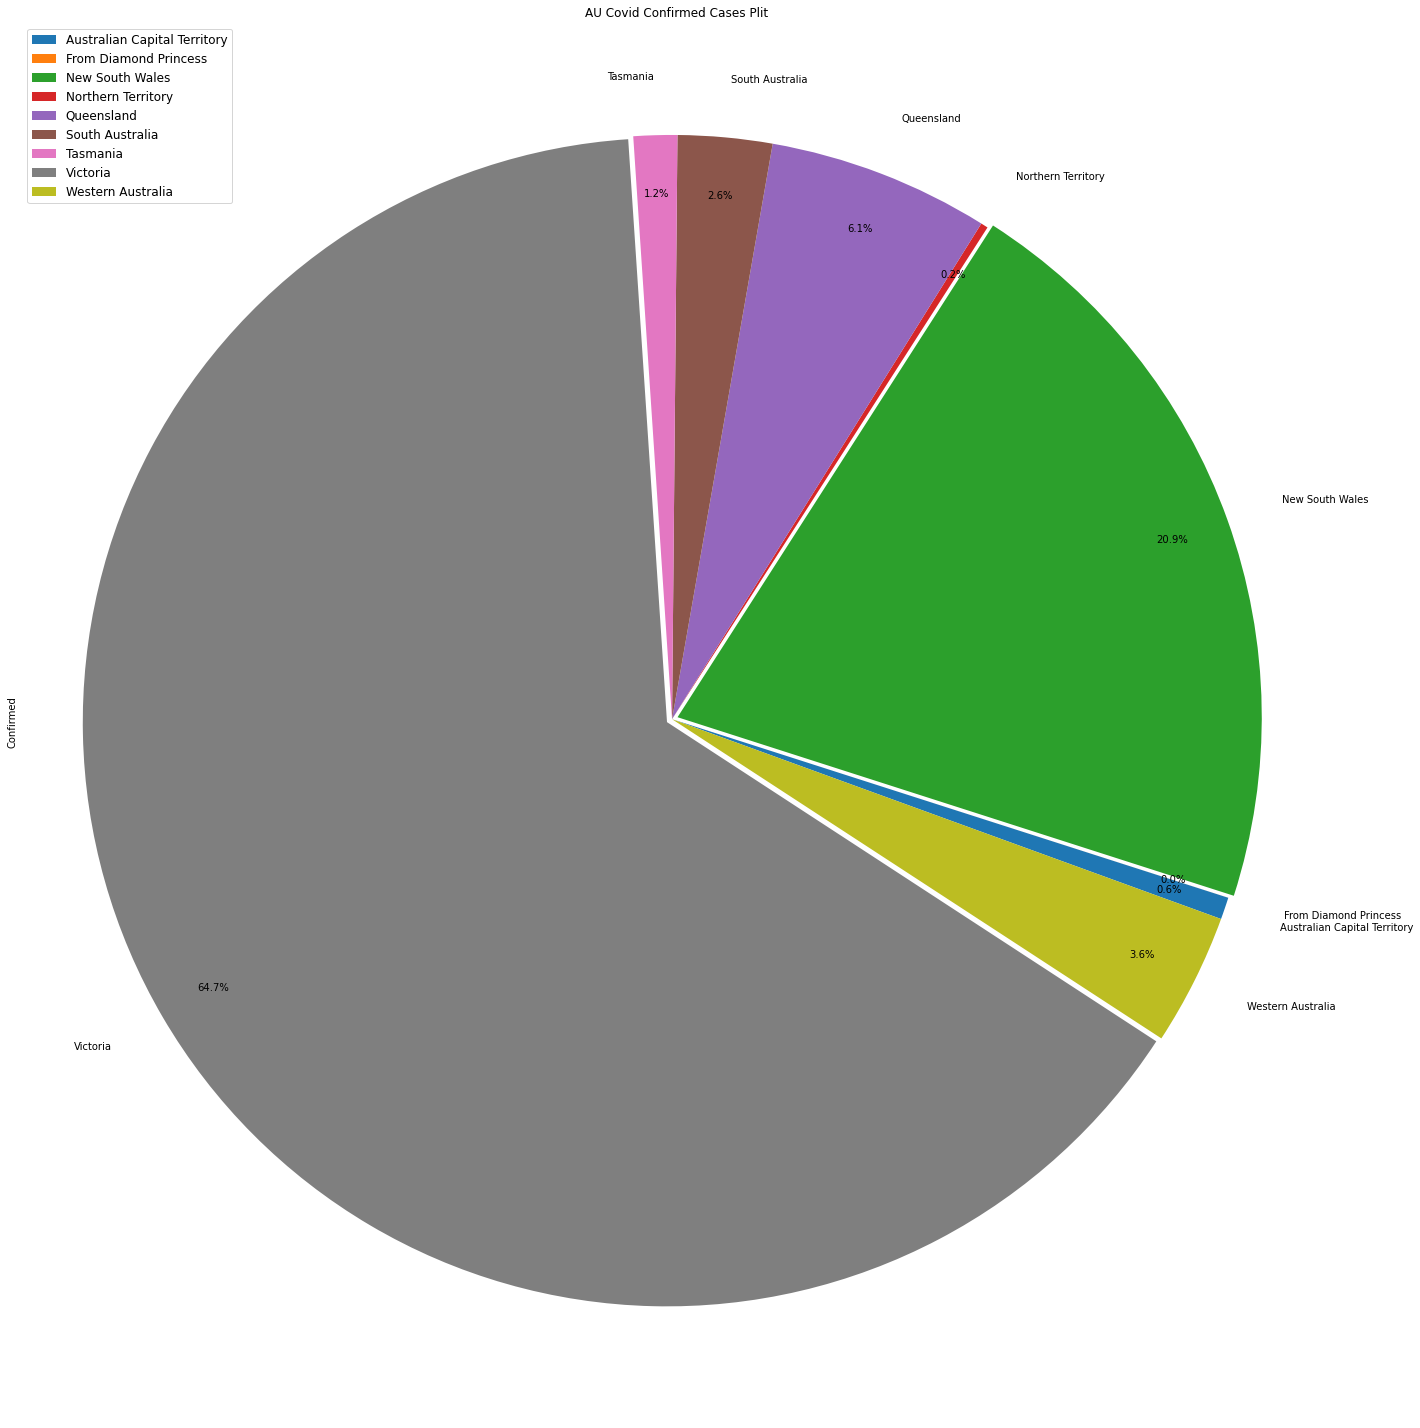

In [16]:
confirmed_df = working_df.groupby('state')['Confirmed'].sum()
confirmed_df = pd.DataFrame(confirmed_df)
confirmed_df = confirmed_df[(confirmed_df.T !=0).any()]

confirmed_df

# plot pie
explode = (0,0,0.01,0,0,0,0,0.01,0)

plot = confirmed_df.plot.pie(y='Confirmed',figsize=(20,20), explode =explode, startangle=700, autopct="%1.1f%%",pctdistance=0.9, labeldistance=1.1)
plt.title("AU Covid Confirmed Cases Plit")
plt.rc('font', size=12)
plt.rc('axes', titlesize=10) 
plt.rc('axes', labelsize=20)
plt.legend(loc="upper left", fontsize=12)
plt.axis("equal")
plt.tight_layout()
plt.show()

## Analysing Mobility Changes to Public Transport
Mobility trends for places that are public transport hubs, such as underground, bus and train stations.
Baseline is considered as zero, indicating no changes from prveious years.

In [17]:
# Groupby states
act_df = working_df.loc[working_df["state"] == "Australian Capital Territory",:]
nsw_df = working_df.loc[working_df["state"] == "New South Wales",:]
nt_df = working_df.loc[working_df["state"] == "Northern Territory",:]
qld_df = working_df.loc[working_df["state"] == "Queensland",:]
sa_df = working_df.loc[working_df["state"] == "South Australia",:]
tas_df = working_df.loc[working_df["state"] == "Tasmania",:]
vic_df = working_df.loc[working_df["state"] == "Victoria",:]
wa_df = working_df.loc[working_df["state"] == "Western Australia",:]

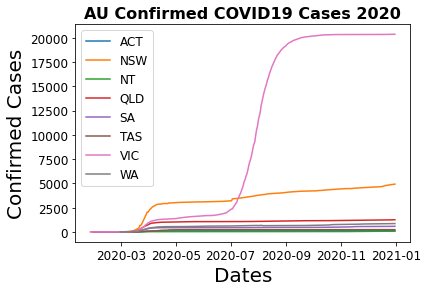

<Figure size 720x3600 with 0 Axes>

In [18]:
# Overview - Confirmed Cases
#Plotting confirmed cases for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['Confirmed']
nsw = nsw_df['Confirmed']
nt = nt_df['Confirmed']
qld = qld_df['Confirmed']
sa = sa_df['Confirmed']
tas = tas_df['Confirmed']
vic = vic_df['Confirmed']
wa = wa_df['Confirmed']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')

plt.legend(loc="upper left")
plt.title("AU Confirmed COVID19 Cases 2020", fontsize=16, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("Confirmed Cases")
plt.figure(figsize=(10, 50))
plt.show()


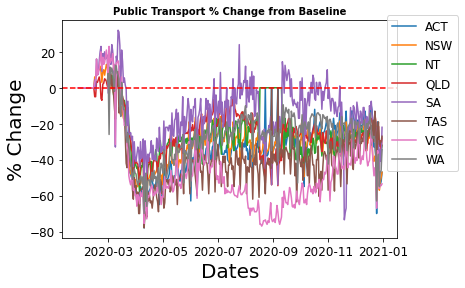

<Figure size 720x3600 with 0 Axes>

In [54]:
# Overview
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['transit_stations_pctchange_to_baseline']
nsw = nsw_df['transit_stations_pctchange_to_baseline']
nt = nt_df['transit_stations_pctchange_to_baseline']
qld = qld_df['transit_stations_pctchange_to_baseline']
sa = sa_df['transit_stations_pctchange_to_baseline']
tas = tas_df['transit_stations_pctchange_to_baseline']
vic = vic_df['transit_stations_pctchange_to_baseline']
wa = wa_df['transit_stations_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.title("Public Transport % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(10, 50))
plt.show()


In [20]:
# looking at average over all changes to catching public transport to see which states were the most impacted
pt_avg_change = pd.DataFrame(pt_avg_change)
#drop 0 values
pt_avg_change = pt_avg_change[(pt_avg_change.T !=0).any()]
pt_avg_change

,transit_stations_pctchange_to_baseline
state,
Australian Capital Territory,-34.108844
New South Wales,-27.429412
Northern Territory,-27.140264
Queensland,-23.713650
South Australia,-13.026866
Tasmania,-41.149180
Victoria,-43.850000
Western Australia,-26.973941


Text(0, 0.5, 'AU states')

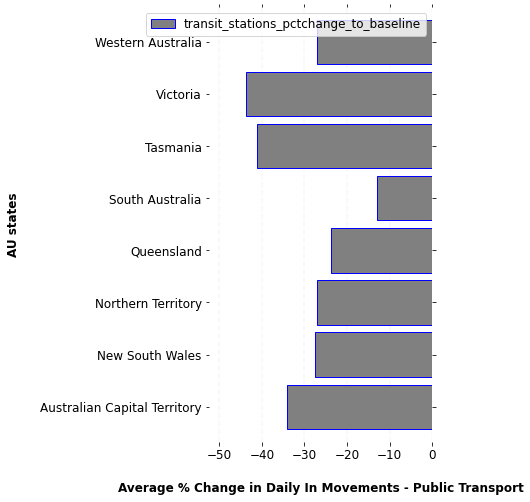

In [21]:
# Plot for visualisation
colors = ['grey']

x = pt_avg_change
ax = x.plot(kind='barh', figsize=(4, 8), color=[colors],edgecolor='blue', zorder=2, width=0.85)
  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Average % Change in Daily In Movements - Public Transport", labelpad=20, weight='bold', size=12)

  # Set y-axis label
ax.set_ylabel("AU states", labelpad=20, weight='bold', size=12)

### Observations - Public Transport Usage and COVID Cases Over Time

- All States saw an above base line usage of public transport at the begining of the year. This trend was increasing in Jan approaching March prior to the Pandemic status being declared.


- All states took a hard dip from Mar towards Apr after the pandemic anouncement was made and spike in confirmed COVID cases.


- The hard dip in public transport usage from Mar - Apr  was likely corrolated to the exponential growth in confirmed cases around the same time across all states.


- Any states that manages to flatten the curve and kept it flatten post the exponetial growth, seen a continual trend in public transport usage that is an upward trajectory towards baseline.


- Most states continue towards a general upward trajectory. Except for QLD SA VIC had another notable dip in Sep due to second wave and increases in number of confirmed cases.


- Whenever there is a hard spike in confirm cases, like that experiened by some states in Sep and Nov. we can see a reponse in hard drop of public transport ultilisation around the same time.


- After April NSW VIC and WA never made it back to baseline for the remainder of the 2020.


- Of all sattes VIC had the most confirmed cases and had continual rise in cases up until Sep. As a result VIC visit and ultilisation of public transport was the most furthest from baseline in Australia. Only in Sep then the curve flatten out was there a steady increase back towards baseline.

## Recommendations
Our recommendations to for the furture around public transport planning would be:
    
- To reduce level of public transports in anticipation of a public announcement that could potentially affect all Australians. i.e. another pandemic or natural disasters.
    
    
- For Covid an event leading up to rise in number of cases like a superspreader event. If there are a likelyhood of increases in the number of cases. it should be followed by reduction in public transports in anticipation for the  dips from baseline of public transport usage.
    
    
- Once the cases are under control and the curve is flattened for approximately 1 month, begin to slowly introduce more public transport as the usage levels will slowly climb back up towards baseline. 
    

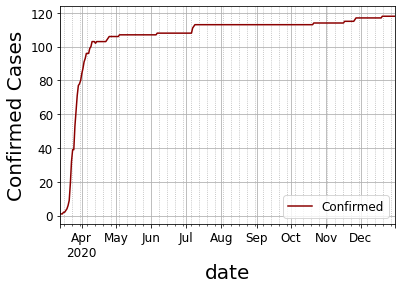

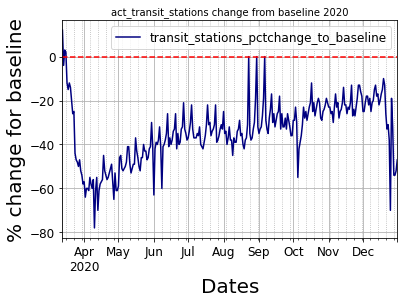

In [22]:
#Do individual analysis for every state

# ACT

#Plotting change in base line vs confirmcases for comparison
act_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

act_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("act_transit_stations change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

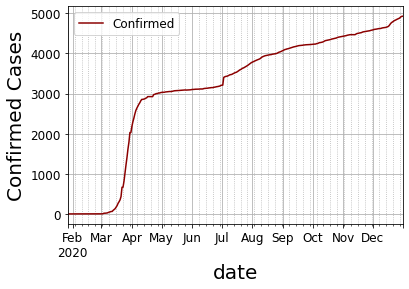

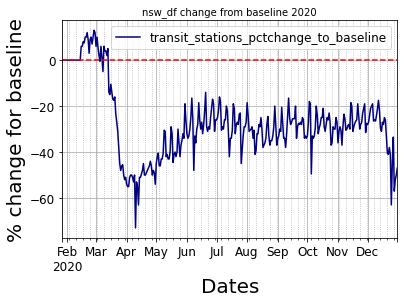

In [23]:
# NSW

#Plotting change in base line vs confirmcases for comparison
nsw_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


nsw_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("nsw_df change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


plt.show()

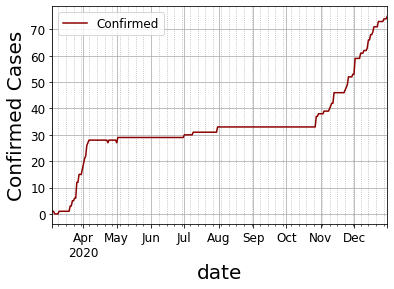

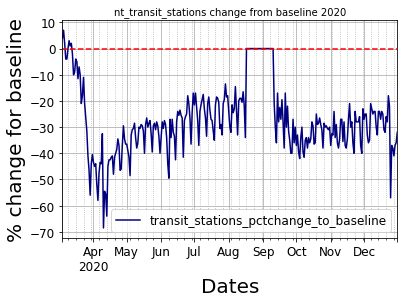

In [24]:
# NT

#Plotting change in base line vs confirmcases for comparison
nt_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

nt_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("nt_transit_stations change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


plt.show()

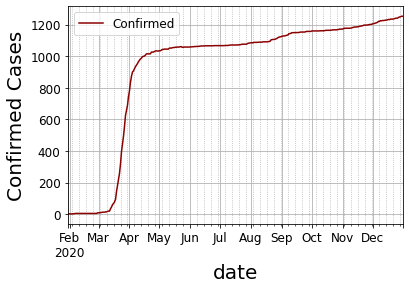

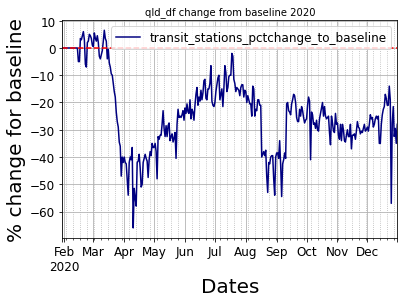

In [25]:
# QLD

#Plotting change in base line vs confirmcases for comparison
qld_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


qld_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("qld_df change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


plt.show()

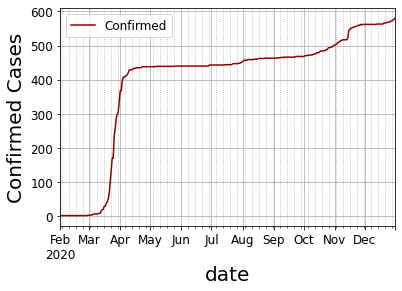

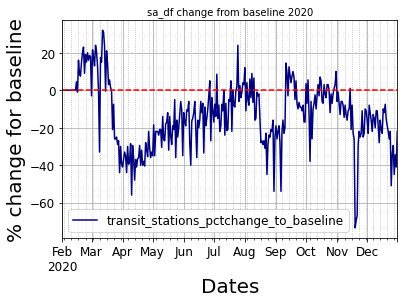

In [26]:
# SA

#Plotting change in base line vs confirmcases for comparison
sa_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


sa_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("sa_df change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')



plt.show()

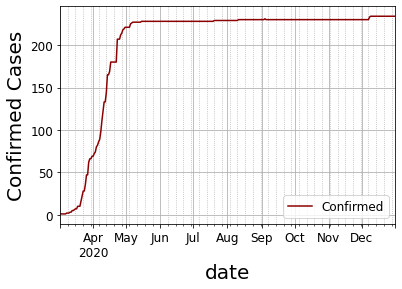

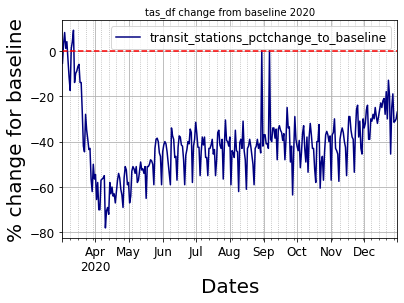

In [27]:
# TAS
# Plotting change in base line vs confirmcases for comparison
tas_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

tas_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("tas_df change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

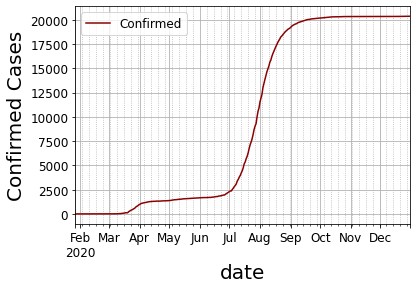

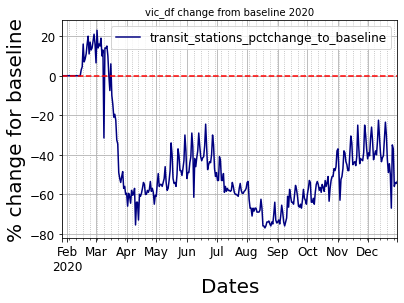

In [28]:
# VIC

#Plotting change in base line vs confirmcases for comparison
vic_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


vic_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("vic_df change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


plt.show()

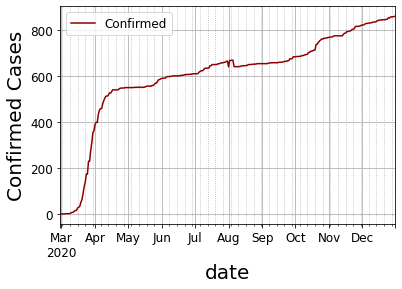

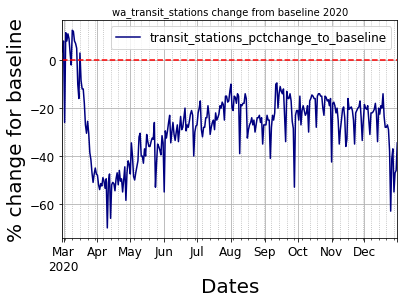

In [29]:
# WA
#Plotting change in base line vs confirmcases for comparison
wa_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

wa_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("wa_transit_stations change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

## Observed Mobility Changes to Workplace
Mobility trends for places of work.

- Similar observations can be made of steep declines from MAR - APR across all states. Possibly due to the announcement of Pandemic status and rising numbers of confirmed cases.

- However, mobility to workplaces has more steep declines throughout the year. Especially noticeable around the JUN, AUG & OCT periods. (lockdowns?)

- Most States managed to make their way back to or aboved baseline most a round the NOV - DEC period.

- All except VIC who never made it back to base line for 2020. This possibly due to VIC having the longest period of lockdowns out of all states.

## Recomendations
- COVID case numbers seems to have a delayed affect on movement to workplaces. Even when curve has flatten workplace policies and lockdowns can cause negative spikes. This must be factored in when reducing level of services.

In [30]:
workplace_avg_change = pd.DataFrame(workplace_avg_change)
#drop 0 values
workplace_avg_change = workplace_avg_change[(workplace_avg_change.T !=0).any()]
workplace_avg_change

,workplaces_pctchange_to_baseline
state,
Australian Capital Territory,-15.955782
New South Wales,-10.891176
Northern Territory,3.049505
Queensland,-6.942136
South Australia,-10.076119
Tasmania,-8.993443
Victoria,-22.116176
Western Australia,-8.581433


Text(0, 0.5, 'AU states')

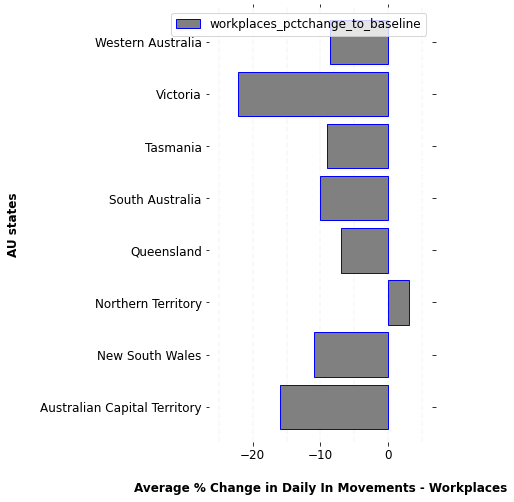

In [31]:
# Plot for visualisation
colors = ['grey']

x = workplace_avg_change
ax = x.plot(kind='barh', figsize=(4, 8), color=[colors],edgecolor='blue', zorder=2, width=0.85)
  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Average % Change in Daily In Movements - Workplaces", labelpad=20, weight='bold', size=12)

  # Set y-axis label
ax.set_ylabel("AU states", labelpad=20, weight='bold', size=12)

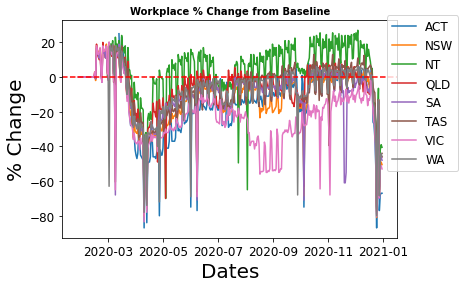

<Figure size 3600x3600 with 0 Axes>

In [32]:
# Overview
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['workplaces_pctchange_to_baseline']
nsw = nsw_df['workplaces_pctchange_to_baseline']
nt = nt_df['workplaces_pctchange_to_baseline']
qld = qld_df['workplaces_pctchange_to_baseline']
sa = sa_df['workplaces_pctchange_to_baseline']
tas = tas_df['workplaces_pctchange_to_baseline']
vic = vic_df['workplaces_pctchange_to_baseline']
wa = wa_df['workplaces_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.title("Workplace % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(50, 50))
plt.show()


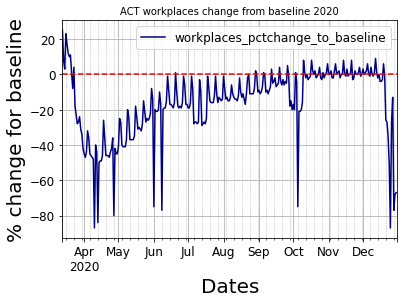

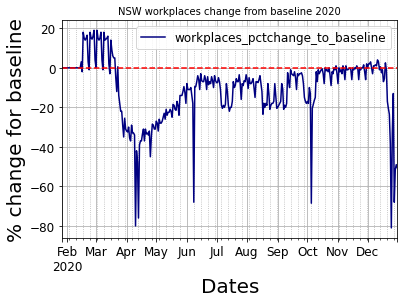

In [33]:
#ACT
act_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("ACT workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#NSW
nsw_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("NSW workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

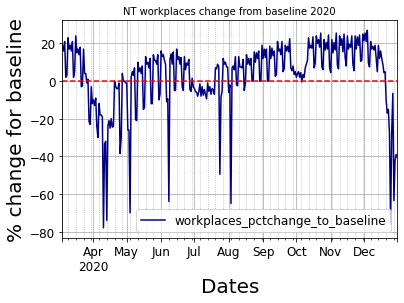

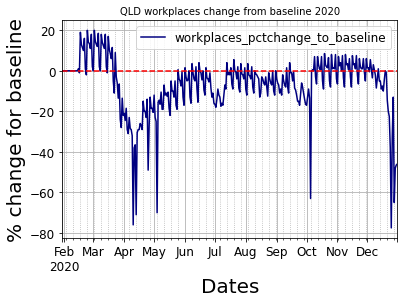

In [34]:
#NT
nt_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("NT workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#QLD
qld_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("QLD workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

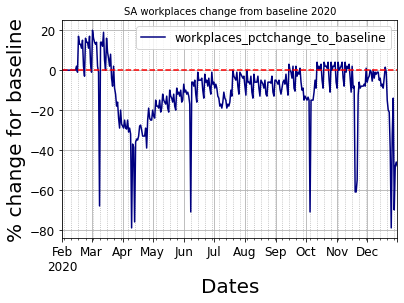

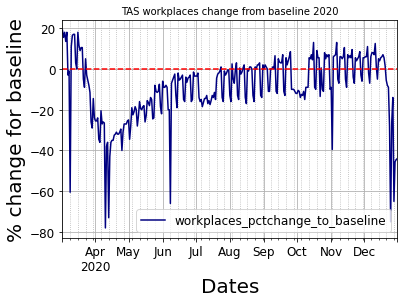

In [35]:
#SA
sa_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("SA workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#TAS
tas_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("TAS workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

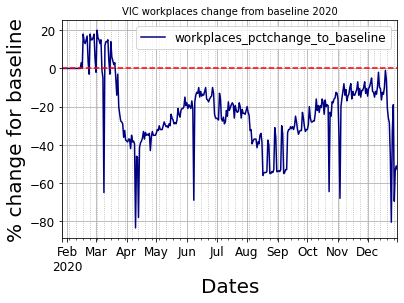

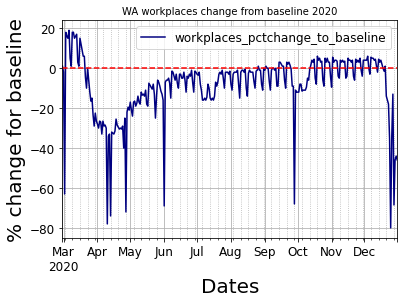

In [36]:
#VIC
vic_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("VIC workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#WA
wa_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("WA workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

## Observed Mobility Changes to Retail
Mobility trends for places such as restaurants, cafés, shopping centres,
theme parks, museums, libraries and cinemas.

In [37]:
retail_avg_change = pd.DataFrame(retail_avg_change)
#drop 0 values
retail_avg_change = retail_avg_change[(retail_avg_change.T !=0).any()]
retail_avg_change

,retail_recreation_pctchange_to_baseline
state,
Australian Capital Territory,-15.108844
New South Wales,-10.835294
Northern Territory,6.387789
Queensland,-4.688427
South Australia,-8.286567
Tasmania,-18.940984
Victoria,-25.023529
Western Australia,-4.809446


Text(0, 0.5, 'AU states')

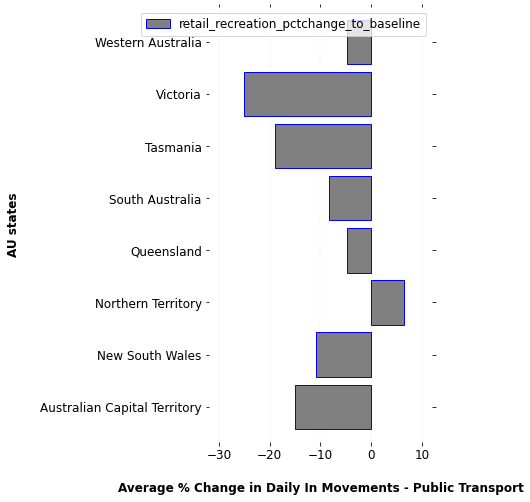

In [38]:
# Plot for visualisation
colors = ['grey']

x = retail_avg_change
ax = x.plot(kind='barh', figsize=(4, 8), color=[colors],edgecolor='blue', zorder=2, width=0.85)
  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Average % Change in Daily In Movements - Public Transport", labelpad=20, weight='bold', size=12)

  # Set y-axis label
ax.set_ylabel("AU states", labelpad=20, weight='bold', size=12)

### Observations - Public Transport Usage and COVID Cases Over Time
- Vitoria is again the most affected

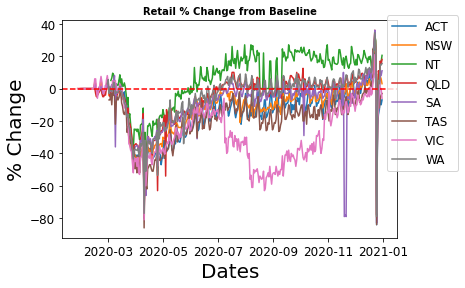

<Figure size 720x3600 with 0 Axes>

In [39]:
# Overview
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['retail_recreation_pctchange_to_baseline']
nsw = nsw_df['retail_recreation_pctchange_to_baseline']
nt = nt_df['retail_recreation_pctchange_to_baseline']
qld = qld_df['retail_recreation_pctchange_to_baseline']
sa = sa_df['retail_recreation_pctchange_to_baseline']
tas = tas_df['retail_recreation_pctchange_to_baseline']
vic = vic_df['retail_recreation_pctchange_to_baseline']
wa = wa_df['retail_recreation_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.title("Retail % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(10, 50))
plt.show()

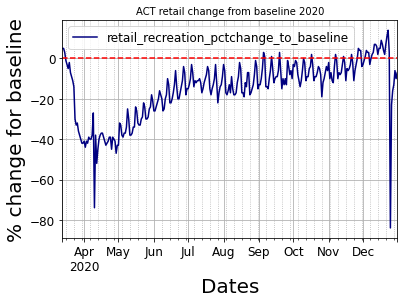

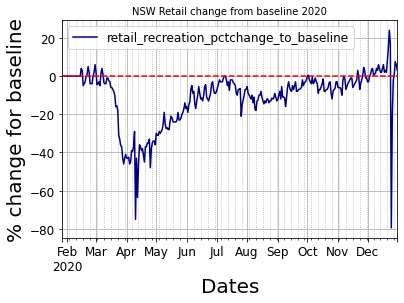

In [40]:
#ACT
act_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("ACT retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#NSW
nsw_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("NSW Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

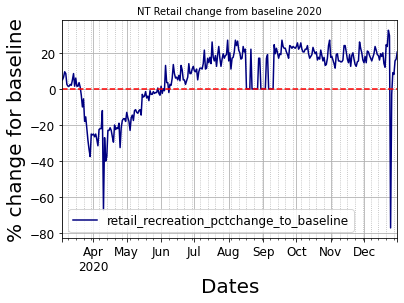

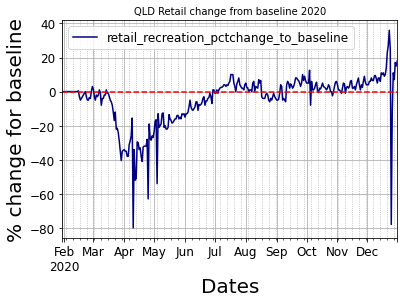

In [41]:
#NT
nt_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("NT Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#QLD
qld_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("QLD Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

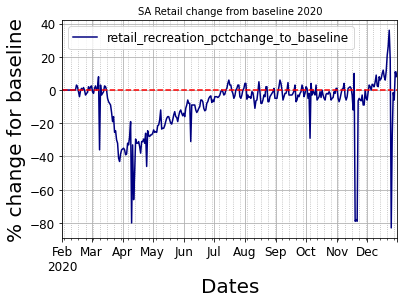

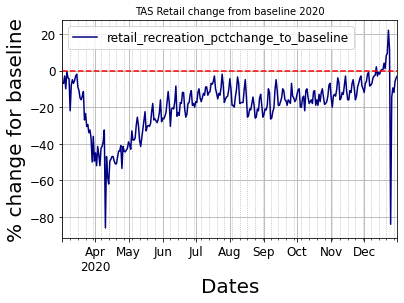

In [42]:
#SA
sa_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("SA Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#TAS
tas_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("TAS Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

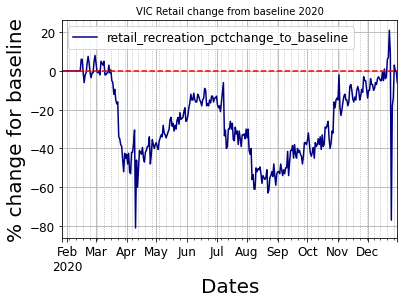

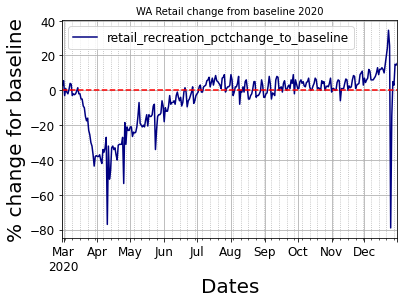

In [43]:
#VIC
vic_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("VIC Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#WA
wa_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("WA Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

## Observed Mobility Changes to Parks
Mobility trends for places like national parks, public beaches, marinas, dog parks, plazas and public gardens.


In [44]:
parks_avg_change = pd.DataFrame(parks_avg_change)
#drop 0 values
parks_avg_change = parks_avg_change[(parks_avg_change.T !=0).any()]
parks_avg_change

,parks_pctchange_to_baseline
state,
Australian Capital Territory,7.979592
New South Wales,-9.327941
Northern Territory,25.917492
Queensland,-3.913947
South Australia,-13.688060
Tasmania,-43.001639
Victoria,-20.257353
Western Australia,-13.859935


Text(0, 0.5, 'AU states')

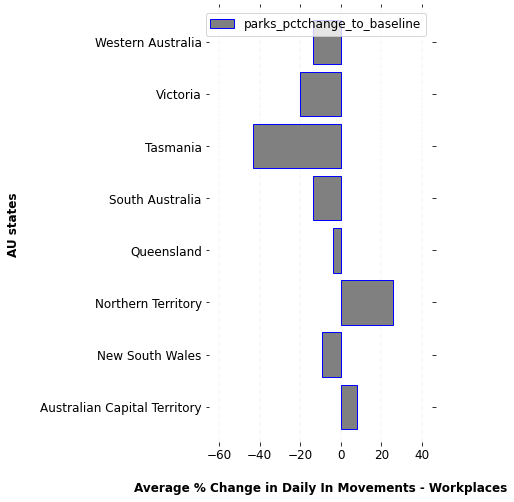

In [45]:
# Plot for visualisation
colors = ['grey']

x = parks_avg_change
ax = x.plot(kind='barh', figsize=(4, 8), color=[colors],edgecolor='blue', zorder=2, width=0.85)
  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Average % Change in Daily In Movements - Workplaces", labelpad=20, weight='bold', size=12)

  # Set y-axis label
ax.set_ylabel("AU states", labelpad=20, weight='bold', size=12)

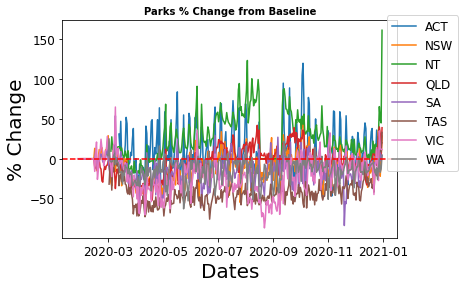

<Figure size 3600x3600 with 0 Axes>

In [46]:
# Overview
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['parks_pctchange_to_baseline']
nsw = nsw_df['parks_pctchange_to_baseline']
nt = nt_df['parks_pctchange_to_baseline']
qld = qld_df['parks_pctchange_to_baseline']
sa = sa_df['parks_pctchange_to_baseline']
tas = tas_df['parks_pctchange_to_baseline']
vic = vic_df['parks_pctchange_to_baseline']
wa = wa_df['parks_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.title("Parks % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(50, 50))
plt.show()

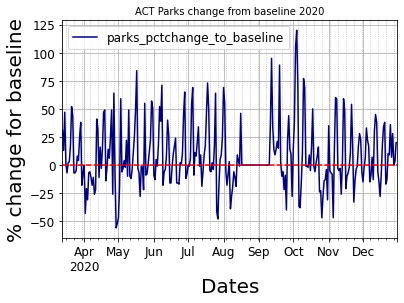

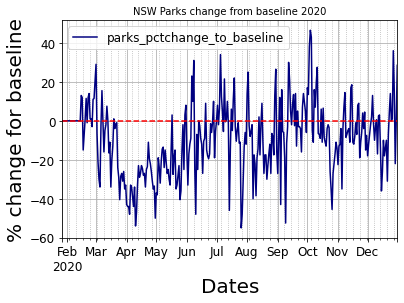

In [47]:
#ACT
act_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("ACT Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#NSW
nsw_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("NSW Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

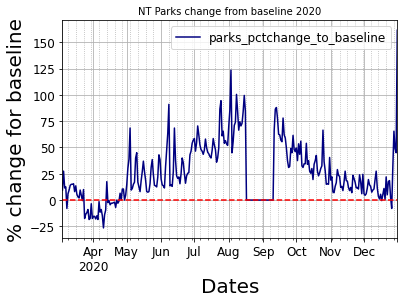

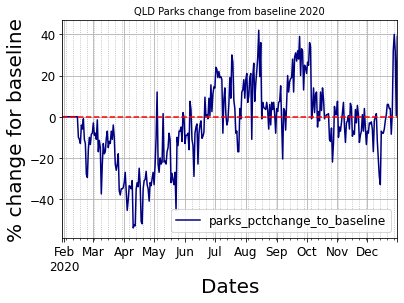

In [48]:
#NT
nt_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("NT Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#QLD
qld_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("QLD Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

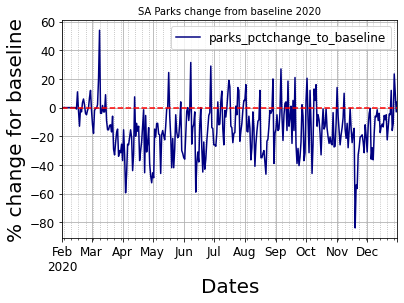

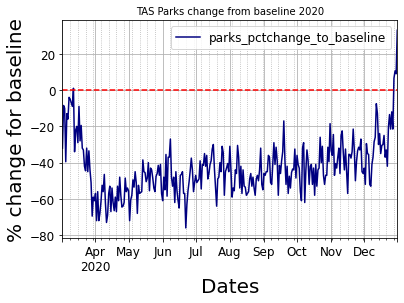

In [49]:
#SA
sa_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("SA Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#TAS
tas_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("TAS Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

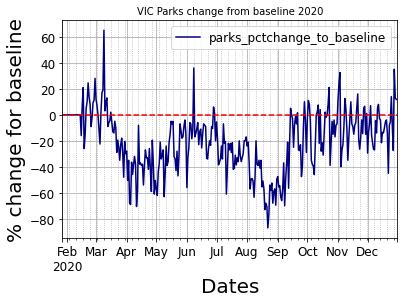

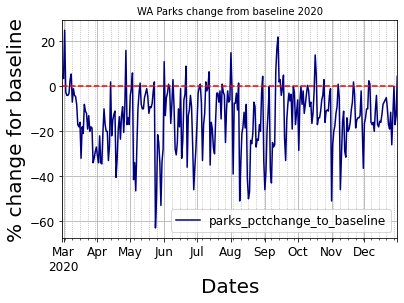

In [50]:
#VIC

vic_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("VIC Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#WA
wa_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("WA Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

## **WIP** Box Plot for Public Transport daily % change for regions
 - looking at the box plot data shown for public transport percentages changes for the year. We can see that they are mostly normally distributed except for VIC whic is slightly skewed. This mean that data can be more easily predicted as they follows the typical pattern for all normal distributions.

<ipython-input-51-84debd5613f4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels,rotation=90, fontsize=12)


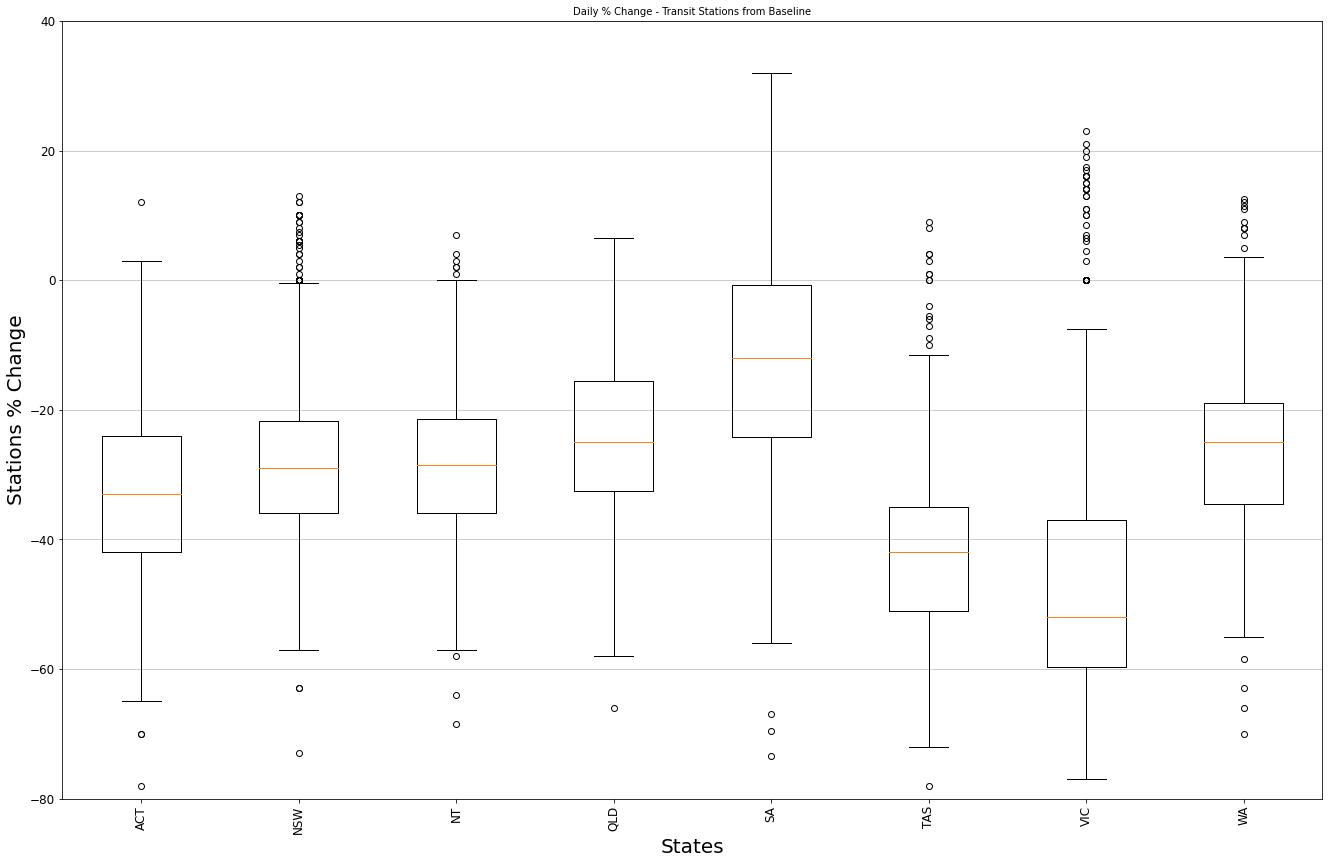

In [51]:
#Box PLots
# get PT daily % change for regions
act_station_plot = act_df["transit_stations_pctchange_to_baseline"]
nsw_station_plot = nsw_df["transit_stations_pctchange_to_baseline"]
nt_station_plot = nt_df["transit_stations_pctchange_to_baseline"]
qld_station_plot = qld_df["transit_stations_pctchange_to_baseline"]
sa_station_plot = sa_df["transit_stations_pctchange_to_baseline"]
tas_station_plot = tas_df["transit_stations_pctchange_to_baseline"]
vic_station_plot = vic_df["transit_stations_pctchange_to_baseline"]
wa_station_plot = wa_df["transit_stations_pctchange_to_baseline"]

# Generate a box plot for each region for analysis
stations_percent_change_boxplot = [act_station_plot, nsw_station_plot, nt_station_plot, qld_station_plot,sa_station_plot,tas_station_plot,vic_station_plot, wa_station_plot]

#ax1.boxplot(stations_percent_change_boxplot)

fig, ax1 = plt.subplots(figsize=(20, 12),)
fig.subplots_adjust(left=0.075, right=0.95, top=1.0, bottom=0.1)

# Set the axes ranges and axes labels
labels=["ACT","NSW","NT","QLD","SA","TAS","VIC","WA"]

ax1.set_xlim(0.5, 8.5)
ax1.set_ylim(-80, 40)
ax1.set_xticklabels(labels,rotation=90, fontsize=12)

ax1.yaxis.grid(True, linestyle='-', which='major', color='grey',alpha=0.5)
               
ax1.set(axisbelow=True, title="Daily % Change - Transit Stations from Baseline",xlabel='States', ylabel='Stations % Change',)
        

ax1.boxplot(stations_percent_change_boxplot)

plt.show()

## WIP - T Test Notes:
We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

Ttest_indResult(statistic=-92.12977606485055, pvalue=2.3240413e-317)

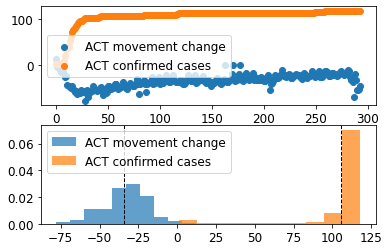

In [52]:
# Independent T-Tests ****W.I.P****
# Independent t-tests will compare the means of 2 independent populations.
population1 = act_df['transit_stations_pctchange_to_baseline'] 
population2 = act_df['Confirmed']
    
    # Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(population1)), population1, label="ACT movement change")
plt.scatter(range(len(population2)), population2, label="ACT confirmed cases")
plt.legend()

    # Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(population1, 10, density=True, alpha=0.7, label="ACT movement change")
plt.hist(population2, 10, density=True, alpha=0.7, label="ACT confirmed cases")
plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()  

# Stats T Test and pvalue
# not assume equal population variance
stats.ttest_ind(population1, population2, equal_var=False)

Ttest_indResult(statistic=-19.80581191191783, pvalue=1.506857351217396e-58)

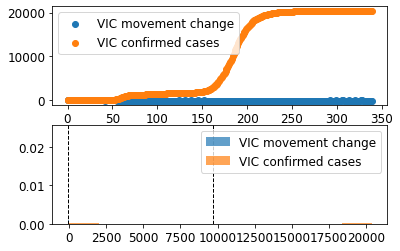

In [53]:
# Independent T-Tests ****WIP****
# Independent t-tests will compare the means of 2 independent populations.
population1 = vic_df['transit_stations_pctchange_to_baseline'] 
population2 = vic_df['Confirmed']
    
    # Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(population1)), population1, label="VIC movement change")
plt.scatter(range(len(population2)), population2, label="VIC confirmed cases")
plt.legend()

    # Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(population1, 10, density=True, alpha=0.7, label="VIC movement change")
plt.hist(population2, 10, density=True, alpha=0.7, label="VIC confirmed cases")
plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()  

# Stats T Test and pvalue
# not assume equal population variance
stats.ttest_ind(population1, population2, equal_var=False)

## Kevin's Section

## Mehrdad's Sections

## Roy's Sections

## An's Section

<AxesSubplot:xlabel='Confirmed', ylabel='transit_stations_pctchange_to_baseline'>

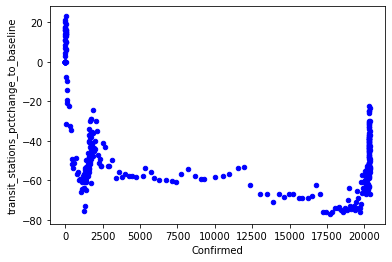

In [201]:
# reviewing the data
vic_df = working_df.loc[working_df["state"]=="Victoria",:]


vic_df.plot(kind = "scatter", x='Confirmed', y='transit_stations_pctchange_to_baseline', color="blue")
